# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

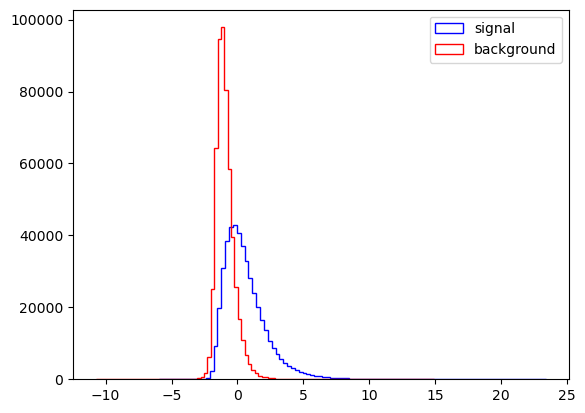

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

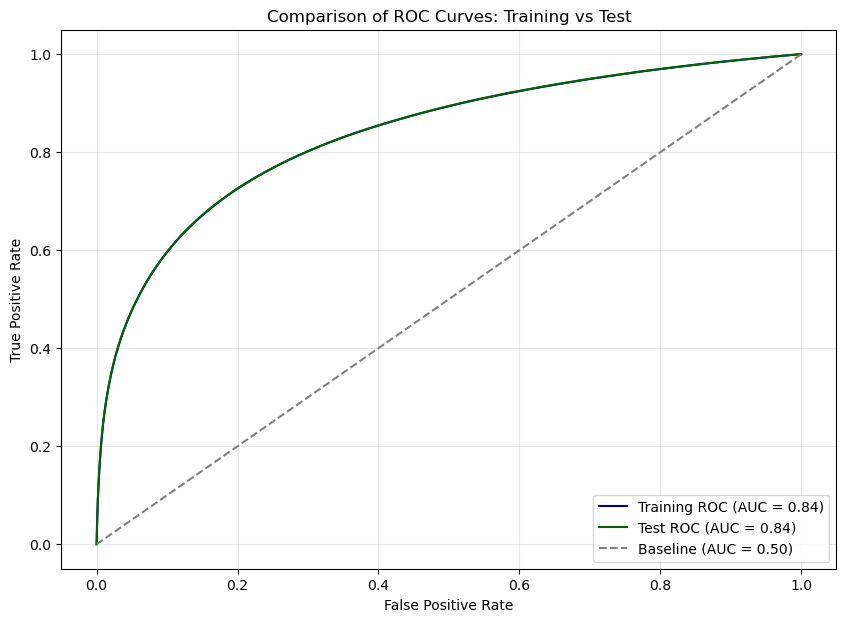

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

train_probs = Fisher.predict_proba(X_Train)[:, 1]  
test_probs = Fisher.predict_proba(X_Test)[:, 1]

train_fpr, train_tpr, train_thresholds = roc_curve(y_Train, train_probs)
test_fpr, test_tpr, test_thresholds = roc_curve(y_Test, test_probs)

train_auc = roc_auc_score(y_Train, train_probs)
test_auc = roc_auc_score(y_Test, test_probs)

plt.figure(figsize=(10, 7))
plt.plot(train_fpr, train_tpr, label=f'Training ROC (AUC = {train_auc:.2f})', color='darkblue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {test_auc:.2f})', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Baseline (AUC = 0.50)")

plt.title('Comparison of ROC Curves: Training vs Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

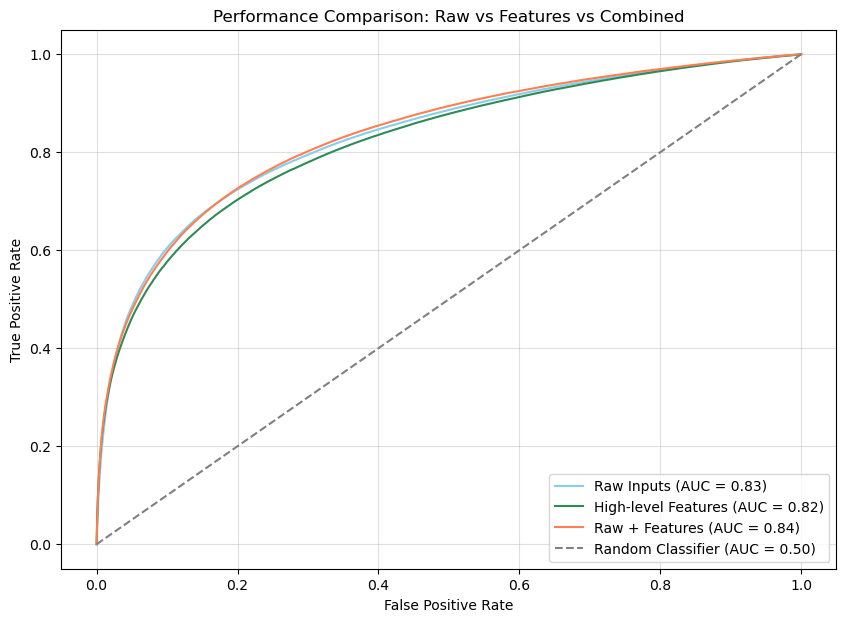

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

low_features = ['l_1_pT', 'l_1_eta', 'l_1_phi', 'l_2_pT', 'l_2_eta', 'l_2_phi', 'MET', 'MET_phi']
high_features = ['MET_rel', 'dPhi_r_b', 'cos_theta_r1', 'R', 'M_TR_2', 'MT2', 'M_R', 'M_Delta_R', 'S_R', 'axial_MET']

raw_inputs = df[low_features].values
derived_inputs = df[high_features].values
combined_inputs = np.concatenate([raw_inputs, derived_inputs], axis=1)

train_size = 4000000
raw_train, raw_test = raw_inputs[:train_size], raw_inputs[train_size:]
features_train, features_test = derived_inputs[:train_size], derived_inputs[train_size:]
combined_train, combined_test = combined_inputs[:train_size], combined_inputs[train_size:]
labels_train, labels_test = df['signal'][:train_size].values, df['signal'][train_size:].values

lda_raw = LinearDiscriminantAnalysis()
lda_features = LinearDiscriminantAnalysis()
lda_combined = LinearDiscriminantAnalysis()

lda_raw.fit(raw_train, labels_train)
lda_features.fit(features_train, labels_train)
lda_combined.fit(combined_train, labels_train)

raw_probs = lda_raw.predict_proba(raw_test)[:, 1]
features_probs = lda_features.predict_proba(features_test)[:, 1]
combined_probs = lda_combined.predict_proba(combined_test)[:, 1]

raw_fpr, raw_tpr, _ = roc_curve(labels_test, raw_probs)
features_fpr, features_tpr, _ = roc_curve(labels_test, features_probs)
combined_fpr, combined_tpr, _ = roc_curve(labels_test, combined_probs)

raw_auc = roc_auc_score(labels_test, raw_probs)
features_auc = roc_auc_score(labels_test, features_probs)
combined_auc = roc_auc_score(labels_test, combined_probs)

plt.figure(figsize=(10, 7))
plt.plot(raw_fpr, raw_tpr, label=f'Raw Inputs (AUC = {raw_auc:.2f})', color='skyblue')
plt.plot(features_fpr, features_tpr, label=f'High-level Features (AUC = {features_auc:.2f})', color='seagreen')
plt.plot(combined_fpr, combined_tpr, label=f'Raw + Features (AUC = {combined_auc:.2f})', color='coral')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier (AUC = 0.50)")

plt.title('Performance Comparison: Raw vs Features vs Combined')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.4)
plt.show()


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

#### part a

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

low_features = ['l_1_pT', 'l_1_eta', 'l_1_phi', 'l_2_pT', 'l_2_eta', 'l_2_phi', 'MET', 'MET_phi']
high_features = ['MET_rel', 'dPhi_r_b', 'cos_theta_r1', 'R', 'M_TR_2', 'MT2', 'M_R', 'M_Delta_R', 'S_R', 'axial_MET']

X = np.hstack([df[low_features].values, df[high_features].values])
y = df['signal'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(probability=True, kernel='rbf', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

svm_probs = svm_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
lr_probs = lr_model.predict_proba(X_test)[:, 1]

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

svm_auc = roc_auc_score(y_test, svm_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

plt.figure(figsize=(10, 8))
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})', color='blue')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

plt.title('Comparison of Classifiers: SVM, Random Forest, Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

print("Accuracy Scores:")
print(f"SVM: {accuracy_score(y_test, svm_model.predict(X_test)):.2f}")
print(f"Random Forest: {accuracy_score(y_test, rf_model.predict(X_test)):.2f}")
print(f"Logistic Regression: {accuracy_score(y_test, lr_model.predict(X_test)):.2f}")

#### part b

#### part c

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 
